In [50]:
import torch
import torch.nn as nn
import torchvision as tv
from torch.utils.data import DataLoader

import numpy as np
import random
import os
from pathlib import Path
import matplotlib.pyplot as plt

from typing import Tuple, List

%matplotlib inline

In [2]:
def get_mnist_ds(is_train:bool):
    return tv.datasets.MNIST(root = Path('mnistdata'),
                             train = is_train,
                             transform = tv.transforms.ToTensor(),
                             target_transform = None,
                             download = True
                            )

In [3]:
def get_mnist_ds_loader(batch_size):
        train_ds = get_mnist_ds(is_train = True)
        valid_ds = get_mnist_ds(is_train = False)
        
        return (DataLoader(train_ds, batch_size, shuffle = True),
                DataLoader(valid_ds, 2*batch_size, shuffle = False))
    

In [4]:
train_dl, valid_dl = get_mnist_ds_loader(32)

In [5]:
len(train_dl.dataset), len(valid_dl.dataset)

(60000, 10000)

In [6]:
train_dl.dataset.data.shape

torch.Size([60000, 28, 28])

torch.Size([32, 1, 28, 28])
torch.Size([32])


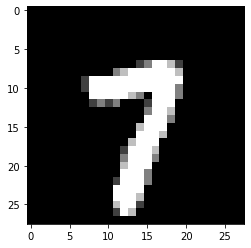

torch.Size([32, 1, 28, 28])
torch.Size([32])


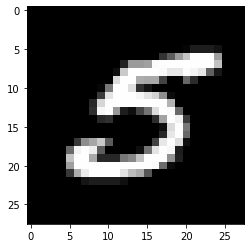

torch.Size([32, 1, 28, 28])
torch.Size([32])


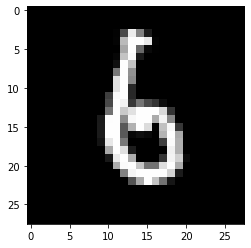

torch.Size([32, 1, 28, 28])
torch.Size([32])


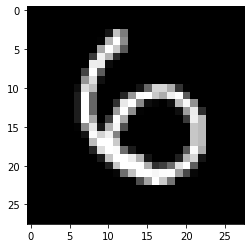

torch.Size([32, 1, 28, 28])
torch.Size([32])


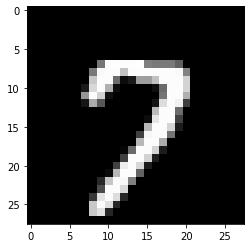

In [7]:
for i, x in enumerate(train_dl):
    print(x[0].shape)
    print(x[1].shape)
    plt.imshow(x[0][0][0],cmap='gray')
    plt.show()
    if i>3 : break

In [8]:
class Encoder(nn.Module):
    def __init__(self, inp_size: Tuple[int,int], hidden_size: int, out_size: int):
        
        super().__init__()
        
        self.enc = nn.Sequential(nn.Flatten(),
                                 nn.Linear(np.prod(inp_size), hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, out_size))
        
    def forward(self, x):
        return self.enc(x)
        

In [9]:
class Decoder(nn.Module):
    def __init__(self, inp_size: int, hidden_size: int, out_size: Tuple[int,int]):
        
        super().__init__()
        self.out_size = out_size
        self.dec = nn.Sequential(nn.Linear(inp_size, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, np.prod(out_size)),
                                 nn.Sigmoid())
        
    def forward(self, x):
        x = self.dec(x)
        return x.view((x.shape[0],*self.out_size))

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, inp_size: Tuple[int,int], hidden_size: int, out_size: int):
        super().__init__()
        
        self.enc = Encoder(inp_size, hidden_size, out_size)
        self.dec = Decoder(out_size, hidden_size, inp_size)
        
    def forward(self, x):
        out = self.enc(x)
        out = self.dec(out)
        
        return out

In [22]:
device = torch.device('cpu')

In [11]:
ae = AutoEncoder(inp_size=(28,28),hidden_size=512,out_size=20)
ae

AutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=20, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

In [12]:
x, y = valid_dl.dataset[30]

In [13]:
print(x.shape)
print(x.requires_grad)

torch.Size([1, 28, 28])
False


In [14]:
with torch.no_grad():
    out = ae(x)

In [15]:
print(out.shape)
print(out.requires_grad)

torch.Size([1, 28, 28])
False


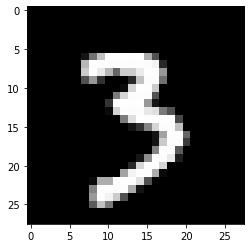

In [16]:
plt.imshow(x[0], cmap='gray')

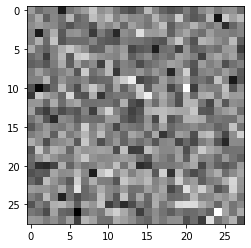

In [17]:
plt.imshow(out[0],cmap='gray')

In [18]:
def show_summary(valid_dl: DataLoader, model: nn.Module):
    ELEM_NUM = 10
    
    device = model.parameters().__next__().device
    ae.eval()

    actual_list = [x for i, (x, y) in enumerate(valid_dl.dataset) if i < ELEM_NUM]
    
    with torch.no_grad():
        actuals_batch = torch.cat(actual_list).unsqueeze(1)
        reconst_batch = ae(actuals_batch.to(device)).cpu().unsqueeze(1)
    
    ae.train()
    
    grid_elems = [*actuals_batch, *reconst_batch]

    grid = tv.utils.make_grid(grid_elems, nrow=ELEM_NUM, padding=1, pad_value =1)
  
    plt.figure(figsize=(15,15))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

In [19]:
def show_summary_1(valid_dl:DataLoader, model: nn.Module):
    ELEM_NUM = 10
    
    device = model.parameters().__next__().device
    
    ae.eval()
    
    actuals, reconst = [], []
    
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl.dataset):
            actuals.append(x)
            reconst.append(ae(x.to(device).cpu()))
            if i == ELEM_NUM-1: break
    
    ae.train()
    
    grid_elems = [*actuals, *reconst]
    grid = tv.utils.make_grid(grid_elems, nrow=ELEM_NUM, padding=1,pad_value=1)

    plt.figure(figsize=(15,15))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

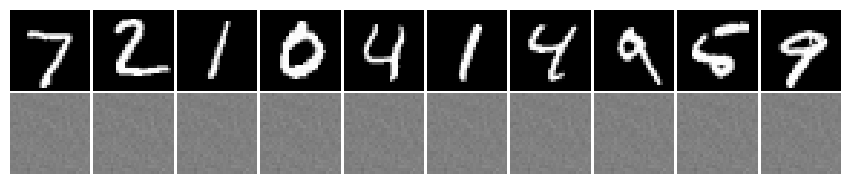

Wall time: 1.21 s


In [20]:
%%time
show_summary(valid_dl,ae)

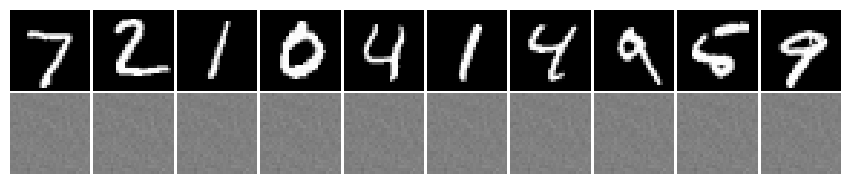

Wall time: 114 ms


In [21]:
%%time
show_summary_1(valid_dl,ae)

In [51]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [52]:
seed_everything()

In [54]:
ae.apply(lambda m: nn.init.xavier_normal_(m.parameters()))

AttributeError: 'generator' object has no attribute 'dim'

epoch 0 | iter 0 | cost 0.0126


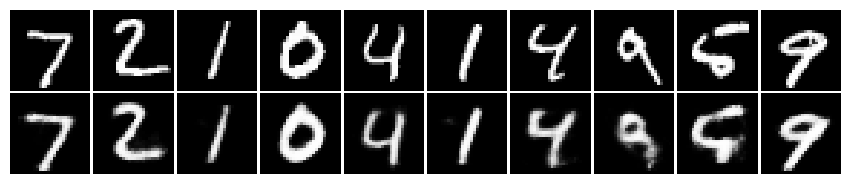

epoch 0 | iter 10 | cost 0.0124
epoch 0 | iter 20 | cost 0.0123
epoch 0 | iter 30 | cost 0.0095
epoch 0 | iter 40 | cost 0.0132
epoch 0 | iter 50 | cost 0.0120


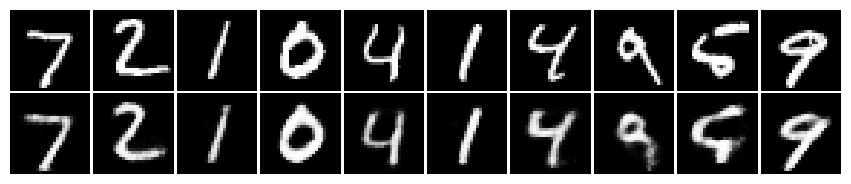

epoch 0 | iter 60 | cost 0.0127
epoch 0 | iter 70 | cost 0.0104
epoch 0 | iter 80 | cost 0.0107
epoch 0 | iter 90 | cost 0.0131
epoch 0 | iter 100 | cost 0.0111


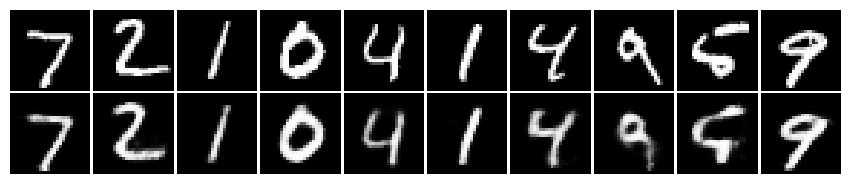

epoch 0 | iter 110 | cost 0.0108
epoch 0 | iter 120 | cost 0.0109
epoch 0 | iter 130 | cost 0.0106
epoch 0 | iter 140 | cost 0.0116
epoch 0 | iter 150 | cost 0.0116


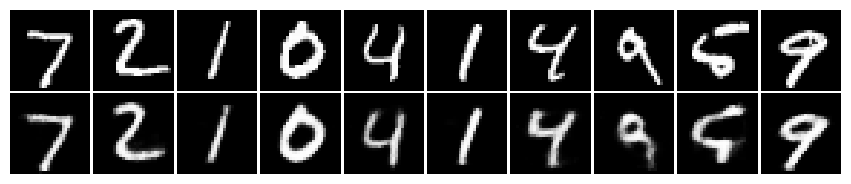

epoch 0 | iter 160 | cost 0.0121
epoch 0 | iter 170 | cost 0.0104
epoch 0 | iter 180 | cost 0.0099
epoch 0 | iter 190 | cost 0.0096
epoch 0 | iter 200 | cost 0.0140


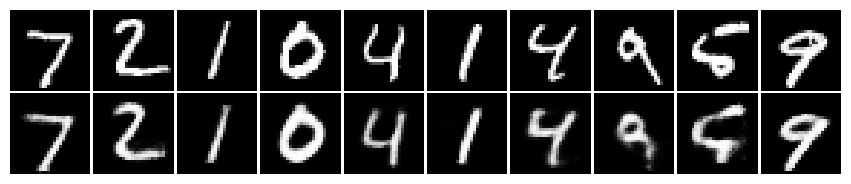

epoch 0 | iter 210 | cost 0.0109
epoch 0 | iter 220 | cost 0.0131
epoch 0 | iter 230 | cost 0.0112
epoch 0 | iter 240 | cost 0.0103
epoch 0 | iter 250 | cost 0.0118


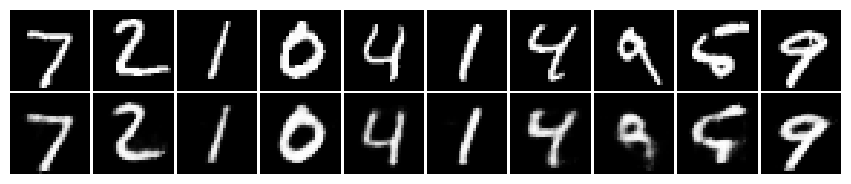

epoch 0 | iter 260 | cost 0.0104
epoch 0 | iter 270 | cost 0.0095
epoch 0 | iter 280 | cost 0.0115
epoch 0 | iter 290 | cost 0.0118
epoch 0 | iter 300 | cost 0.0126


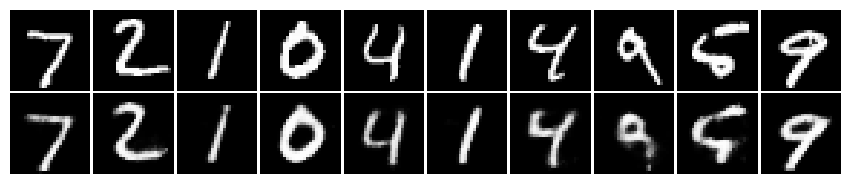

epoch 0 | iter 310 | cost 0.0110
epoch 0 | iter 320 | cost 0.0106
epoch 0 | iter 330 | cost 0.0115
epoch 0 | iter 340 | cost 0.0093
epoch 0 | iter 350 | cost 0.0105


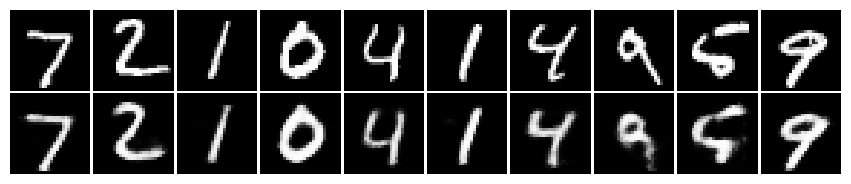

epoch 0 | iter 360 | cost 0.0123
epoch 0 | iter 370 | cost 0.0097
epoch 0 | iter 380 | cost 0.0092
epoch 0 | iter 390 | cost 0.0109
epoch 0 | iter 400 | cost 0.0114


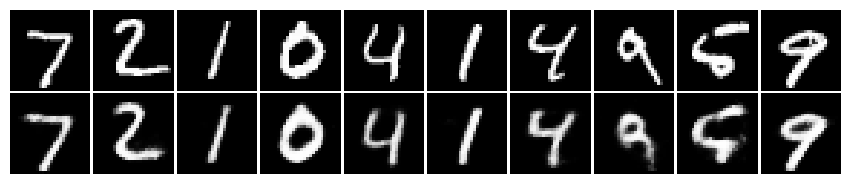

epoch 0 | iter 410 | cost 0.0119
epoch 0 | iter 420 | cost 0.0122
epoch 0 | iter 430 | cost 0.0120
epoch 0 | iter 440 | cost 0.0093
epoch 0 | iter 450 | cost 0.0090


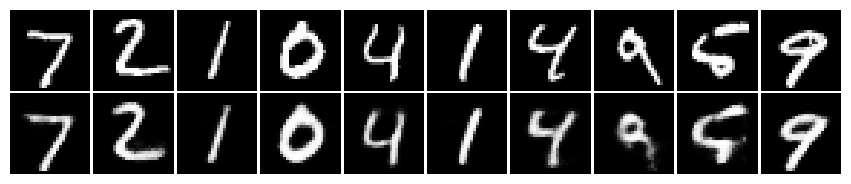

epoch 0 | iter 460 | cost 0.0117
epoch 0 | iter 470 | cost 0.0101
epoch 0 | iter 480 | cost 0.0105
epoch 0 | iter 490 | cost 0.0120
epoch 0 | iter 500 | cost 0.0104


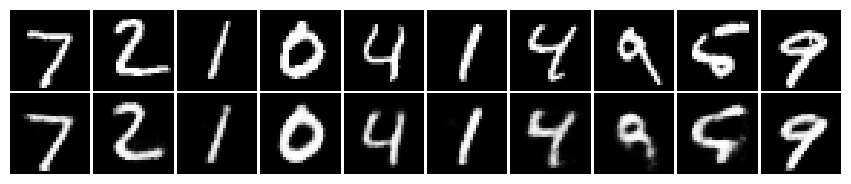

epoch 0 | iter 510 | cost 0.0087
epoch 0 | iter 520 | cost 0.0111
epoch 0 | iter 530 | cost 0.0099
epoch 0 | iter 540 | cost 0.0105
epoch 0 | iter 550 | cost 0.0105


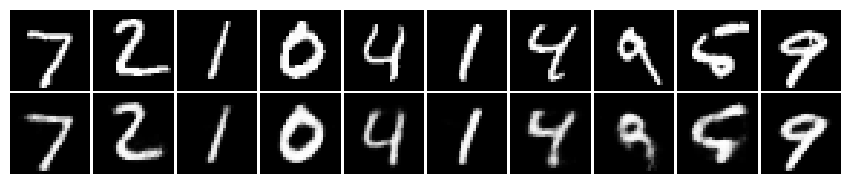

epoch 0 | iter 560 | cost 0.0101
epoch 0 | iter 570 | cost 0.0105
epoch 0 | iter 580 | cost 0.0093
epoch 0 | iter 590 | cost 0.0100
epoch 0 | iter 600 | cost 0.0093


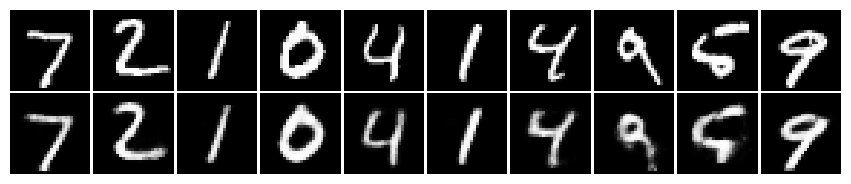

epoch 0 | iter 610 | cost 0.0130
epoch 0 | iter 620 | cost 0.0120
epoch 0 | iter 630 | cost 0.0103
epoch 0 | iter 640 | cost 0.0094
epoch 0 | iter 650 | cost 0.0099


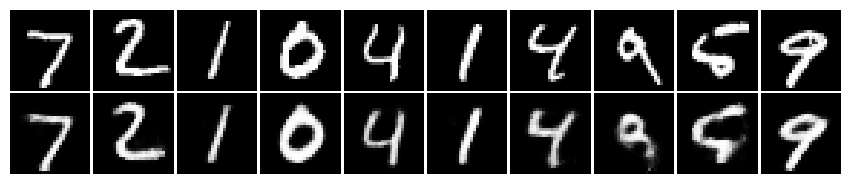

epoch 0 | iter 660 | cost 0.0111
epoch 0 | iter 670 | cost 0.0092
epoch 0 | iter 680 | cost 0.0089
epoch 0 | iter 690 | cost 0.0101
epoch 0 | iter 700 | cost 0.0094


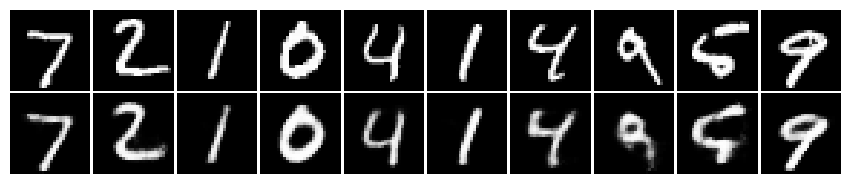

epoch 0 | iter 710 | cost 0.0111
epoch 0 | iter 720 | cost 0.0109
epoch 0 | iter 730 | cost 0.0102
epoch 0 | iter 740 | cost 0.0114
epoch 0 | iter 750 | cost 0.0107


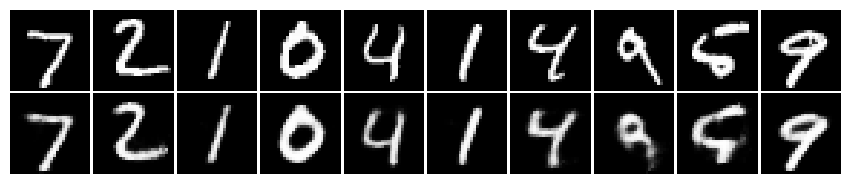

epoch 0 | iter 760 | cost 0.0103
epoch 0 | iter 770 | cost 0.0104
epoch 0 | iter 780 | cost 0.0094
epoch 0 | iter 790 | cost 0.0110
epoch 0 | iter 800 | cost 0.0108


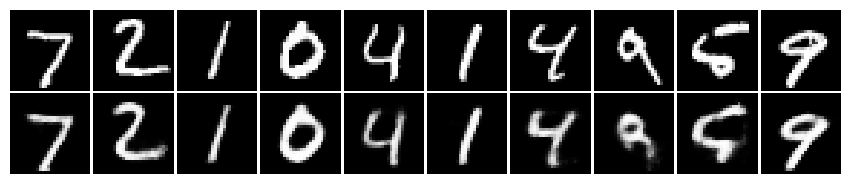

epoch 0 | iter 810 | cost 0.0086
epoch 0 | iter 820 | cost 0.0101
epoch 0 | iter 830 | cost 0.0093
epoch 0 | iter 840 | cost 0.0100
epoch 0 | iter 850 | cost 0.0113


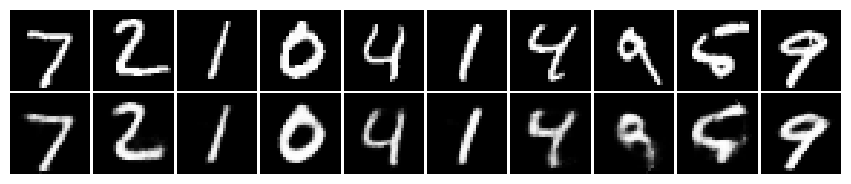

epoch 0 | iter 860 | cost 0.0087
epoch 0 | iter 870 | cost 0.0092
epoch 0 | iter 880 | cost 0.0107
epoch 0 | iter 890 | cost 0.0112
epoch 0 | iter 900 | cost 0.0104


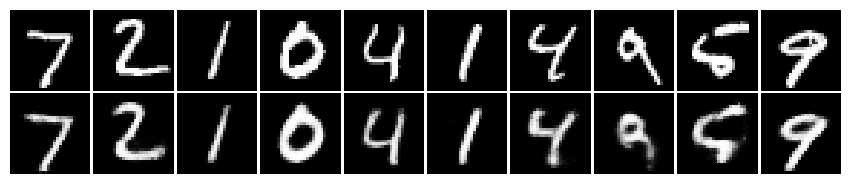

epoch 0 | iter 910 | cost 0.0105
epoch 0 | iter 920 | cost 0.0105
epoch 0 | iter 930 | cost 0.0101
epoch 0 | iter 940 | cost 0.0134
epoch 0 | iter 950 | cost 0.0113


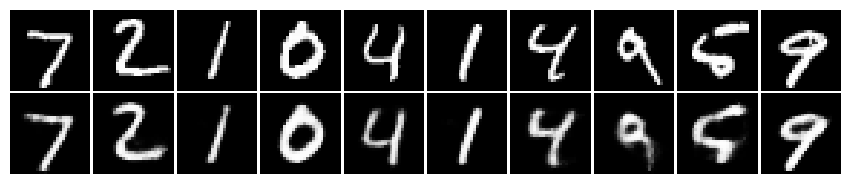

epoch 0 | iter 960 | cost 0.0112
epoch 0 | iter 970 | cost 0.0110
epoch 0 | iter 980 | cost 0.0097
epoch 0 | iter 990 | cost 0.0105
epoch 0 | iter 1000 | cost 0.0083


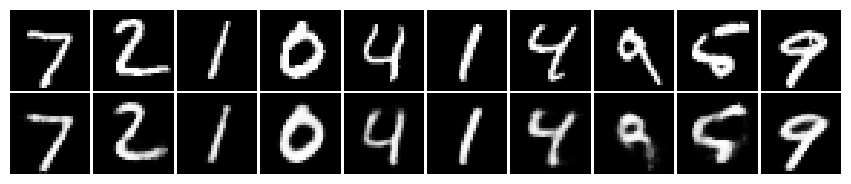

epoch 0 | iter 1010 | cost 0.0106
epoch 0 | iter 1020 | cost 0.0112
epoch 0 | iter 1030 | cost 0.0087
epoch 0 | iter 1040 | cost 0.0121
epoch 0 | iter 1050 | cost 0.0105


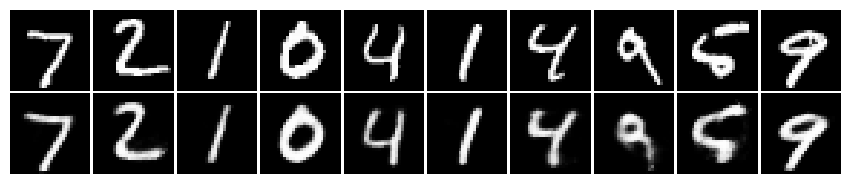

epoch 0 | iter 1060 | cost 0.0106
epoch 0 | iter 1070 | cost 0.0087
epoch 0 | iter 1080 | cost 0.0105
epoch 0 | iter 1090 | cost 0.0092
epoch 0 | iter 1100 | cost 0.0108


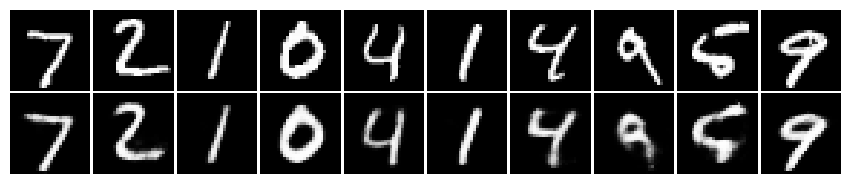

epoch 0 | iter 1110 | cost 0.0101
epoch 0 | iter 1120 | cost 0.0097
epoch 0 | iter 1130 | cost 0.0108
epoch 0 | iter 1140 | cost 0.0111
epoch 0 | iter 1150 | cost 0.0092


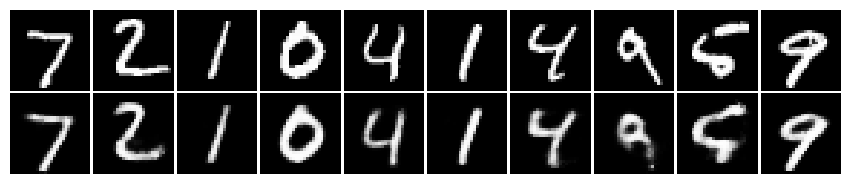

epoch 0 | iter 1160 | cost 0.0124
epoch 0 | iter 1170 | cost 0.0105
epoch 0 | iter 1180 | cost 0.0118
epoch 0 | iter 1190 | cost 0.0114
epoch 0 | iter 1200 | cost 0.0094


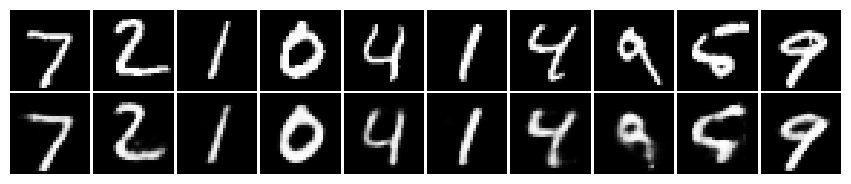

epoch 0 | iter 1210 | cost 0.0087
epoch 0 | iter 1220 | cost 0.0107
epoch 0 | iter 1230 | cost 0.0089
epoch 0 | iter 1240 | cost 0.0101
epoch 0 | iter 1250 | cost 0.0111


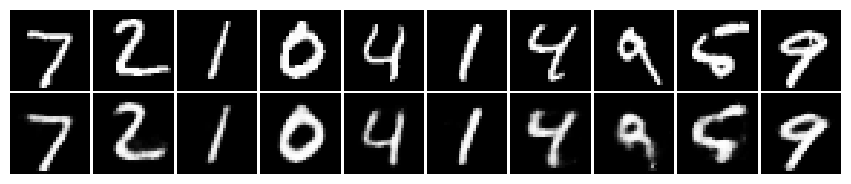

epoch 0 | iter 1260 | cost 0.0112
epoch 0 | iter 1270 | cost 0.0082
epoch 0 | iter 1280 | cost 0.0118
epoch 0 | iter 1290 | cost 0.0106
epoch 0 | iter 1300 | cost 0.0101


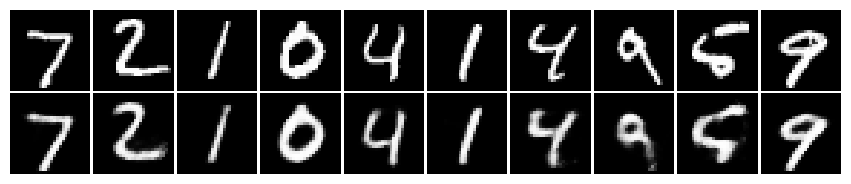

epoch 0 | iter 1310 | cost 0.0079
epoch 0 | iter 1320 | cost 0.0107
epoch 0 | iter 1330 | cost 0.0097
epoch 0 | iter 1340 | cost 0.0114
epoch 0 | iter 1350 | cost 0.0103


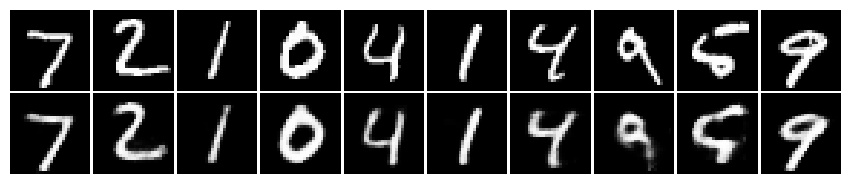

epoch 0 | iter 1360 | cost 0.0097
epoch 0 | iter 1370 | cost 0.0084
epoch 0 | iter 1380 | cost 0.0099
epoch 0 | iter 1390 | cost 0.0110
epoch 0 | iter 1400 | cost 0.0102


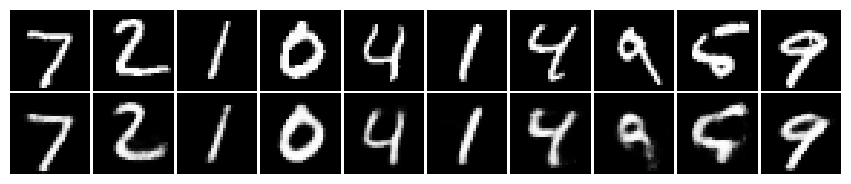

epoch 0 | iter 1410 | cost 0.0087
epoch 0 | iter 1420 | cost 0.0100
epoch 0 | iter 1430 | cost 0.0097
epoch 0 | iter 1440 | cost 0.0096
epoch 0 | iter 1450 | cost 0.0084


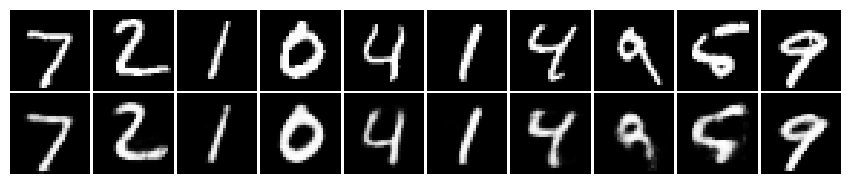

epoch 0 | iter 1460 | cost 0.0078
epoch 0 | iter 1470 | cost 0.0091
epoch 0 | iter 1480 | cost 0.0118
epoch 0 | iter 1490 | cost 0.0111
epoch 0 | iter 1500 | cost 0.0128


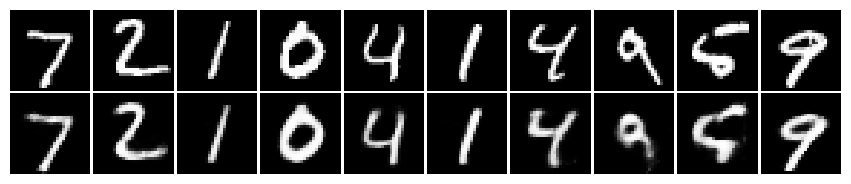

epoch 0 | iter 1510 | cost 0.0109
epoch 0 | iter 1520 | cost 0.0085
epoch 0 | iter 1530 | cost 0.0108
epoch 0 | iter 1540 | cost 0.0102
epoch 0 | iter 1550 | cost 0.0101


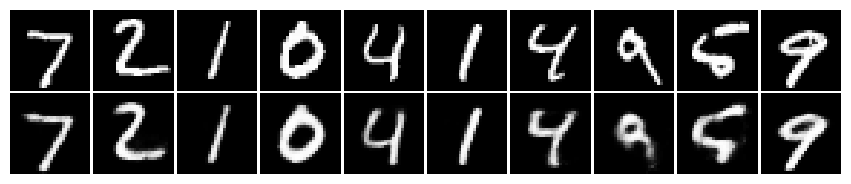

epoch 0 | iter 1560 | cost 0.0106
epoch 0 | iter 1570 | cost 0.0091
epoch 0 | iter 1580 | cost 0.0105
epoch 0 | iter 1590 | cost 0.0112
epoch 0 | iter 1600 | cost 0.0113


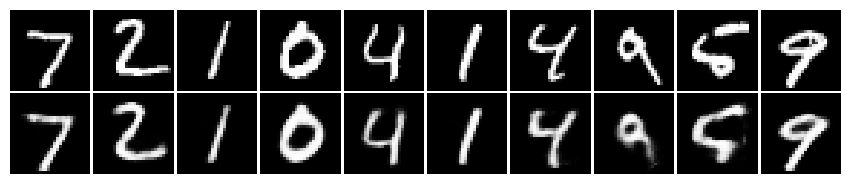

epoch 0 | iter 1610 | cost 0.0097
epoch 0 | iter 1620 | cost 0.0114
epoch 0 | iter 1630 | cost 0.0098
epoch 0 | iter 1640 | cost 0.0081
epoch 0 | iter 1650 | cost 0.0109


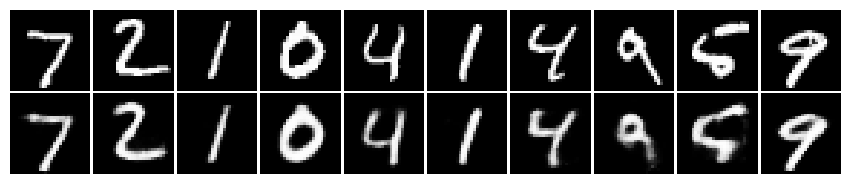

epoch 0 | iter 1660 | cost 0.0087
epoch 0 | iter 1670 | cost 0.0080
epoch 0 | iter 1680 | cost 0.0093
epoch 0 | iter 1690 | cost 0.0089
epoch 0 | iter 1700 | cost 0.0100


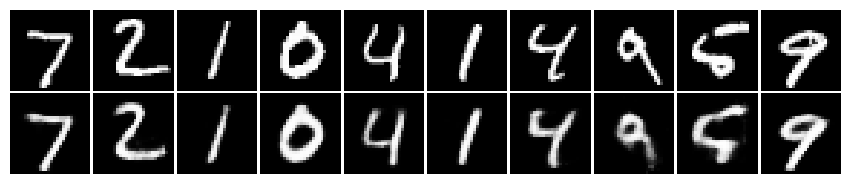

epoch 0 | iter 1710 | cost 0.0114
epoch 0 | iter 1720 | cost 0.0074
epoch 0 | iter 1730 | cost 0.0107
epoch 0 | iter 1740 | cost 0.0110
epoch 0 | iter 1750 | cost 0.0087


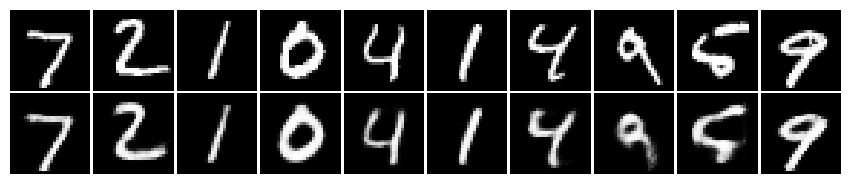

epoch 0 | iter 1760 | cost 0.0104
epoch 0 | iter 1770 | cost 0.0113
epoch 0 | iter 1780 | cost 0.0094
epoch 0 | iter 1790 | cost 0.0089
epoch 0 | iter 1800 | cost 0.0068


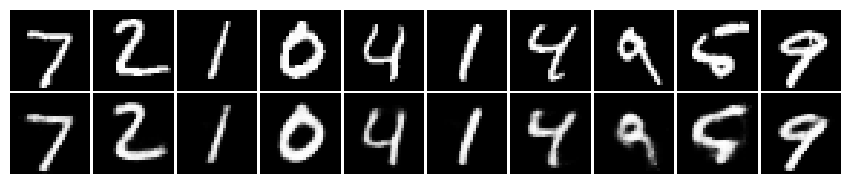

epoch 0 | iter 1810 | cost 0.0077
epoch 0 | iter 1820 | cost 0.0083
epoch 0 | iter 1830 | cost 0.0111
epoch 0 | iter 1840 | cost 0.0088
epoch 0 | iter 1850 | cost 0.0095


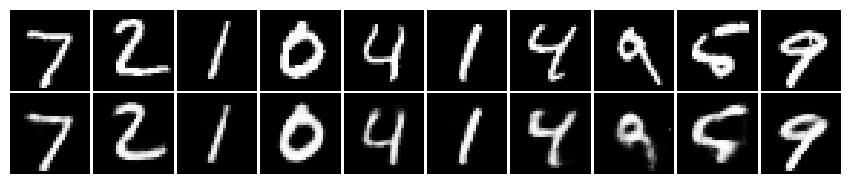

epoch 0 | iter 1860 | cost 0.0102
epoch 0 | iter 1870 | cost 0.0084


In [45]:
total_epochs = 1
mse_loss = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr = 0.0001)

LOG_INTERVAL = 10
SUMMARY_INTERVAL = 50

for epoch in range(0,total_epochs):
    for i, (x, y) in enumerate(train_dl):
        optim.zero_grad()
        target = ae(x.to(device)).unsqueeze(1)
        cost = mse_loss(x, target)
        cost.backward()
        optim.step()
        
        if (i%LOG_INTERVAL) == 0:
            print(f"epoch {epoch} | iter {i} | cost {cost:.4f}")        
        
        if (i%SUMMARY_INTERVAL)==0:
            show_summary_1(valid_dl,ae)